In [ ]:
!pip install -U langchain==0.3.24 langchain-openai==0.3.14 langgraph==0.3.33 langchain-tavily==0.1.6 langgraph-supervisor

In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = ### Your-key
os.environ["LANGCHAIN_PROJECT"] = "Visual-Agentic-AI"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"] = ### Your-key
os.environ["OPENAI_API_KEY"] = ### Your-key

# **Visual Agentic Agent**

In [ ]:
!pip install --upgrade -qq langchain-core langchain-community arxiv duckduckgo-search wikipedia python-magic ultralytics

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/21

In [ ]:
import base64
from typing import Annotated, List, Union

import magic
import requests
from IPython.display import Image, display
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


from typing import Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from langchain_core.tools import tool
from langchain_core.tools.base import ArgsSchema
from pydantic import BaseModel, Field

from ultralytics import YOLO

## **LLMs**

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

In [ ]:
llm.invoke("How are you?")

AIMessage(content="I'm doing well, thank you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'id': 'chatcmpl-BVau6TbFiYs1kRIk5ZvG0iVeDbcvL', 'finish_reason': 'stop', 'logprobs': None}, id='run-0be1663e-43ec-4e21-8898-5a3e651a07b0-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## **Research Agent**

### **Tool**

In [ ]:
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)

In [ ]:
arxiv_wrapper = ArxivAPIWrapper(
    top_k_results=2, doc_content_chars_max=1000
)
arxiv = ArxivQueryRun(
    api_wrapper=arxiv_wrapper,
    description="Search for papers on a given topic using Arxiv"
)
arxiv.invoke("Rotary Positional Encoding")

'Published: 2025-03-03\nTitle: Rotary Outliers and Rotary Offset Features in Large Language Models\nAuthors: André Jonasson\nSummary: Transformer-based Large Language Models (LLMs) rely on positional encodings\nto provide sequence position information to their attention mechanism. Rotary\nPositional Encodings (RoPE), which encode relative position by rotating queries\nand keys, have become widely used in modern LLMs. We study the features and\npatterns that emerge in queries and keys when using rotary embeddings. Our\nanalysis reveals consistent patterns within the same model across layers and\nattention heads and across different models and architectures. We present and\napply analysis techniques and show how the queries and keys use RoPE to\nconstruct various attention patterns, including attention sinks. We find and\nanalyze outliers across models in queries and keys and find that they are\nlikely to be found in rotary features with partial cycles. We derive bounds\nthat tell us wha

In [ ]:
wikipedia_wrapper = WikipediaAPIWrapper()
wikipedia = WikipediaQueryRun(
    api_wrapper=wikipedia_wrapper,
    description="Search for information on a given topic using Wikipedia"
)
wikipedia.invoke("machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.\nStatistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning. \nFrom a theoretical viewpoint, p

### **Agent**

In [ ]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [ ]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    ### Your code here
)

In [ ]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "machine learning"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  arxiv (call_vokIioHd7dvuIgahYJsPTwnS)
 Call ID: call_vokIioHd7dvuIgahYJsPTwnS
  Args:
    query: machine learning
  wikipedia (call_B3VtpI2uHdeHrZvZ59MdwpfH)
 Call ID: call_B3VtpI2uHdeHrZvZ59MdwpfH
  Args:
    query: Machine learning


Update from node tools:


================================= Tool Message =================================
Name: arxiv

Published: 2019-09-08
Title: Lecture Notes: Optimization for Machine Learning
Authors: Elad Hazan
Summary: Lecture notes on optimization for machine learning, derived from a course at
Princeton University and tutorials given in MLSS, Buenos Aires, as well as
Simons Foundation, Berkeley.

Published: 2018-11-11
Title: An Optimal Control View of Adversarial Machine Learning
Authors: Xiaojin Zhu
Summary: I describe an optimal control view of adversarial machine learning, where the
dynamical system is 

## **Vision Agent**

In [ ]:
import os
import magic
import requests
import base64

def encode_image(image_path_or_url: str, get_mime_type: bool = False):
    if image_path_or_url.startswith("http"):
        try:
            response = requests.get(image_path_or_url, stream=True)
            response.raise_for_status()
            image = response.content
            mime_type = response.headers.get("content-type", None)
            base64_encoded = base64.b64encode(image).decode('utf-8')
            if get_mime_type:
                return base64_encoded, mime_type
            else:
                return base64_encoded
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            if get_mime_type:
                return None, None
            else:
                return None
    else:
        if not os.path.exists(image_path_or_url):
            return None, None
        mime_type = magic.Magic(mime=True).from_file(image_path_or_url)
        if mime_type.startswith("image/"):
            with open(image_path_or_url, "rb") as image_file:
                if get_mime_type:
                    return base64.b64encode(image_file.read()).decode("utf-8"), mime_type
                else:
                    return base64.b64encode(image_file.read()).decode("utf-8")
        else:
            if get_mime_type:
                return None, None
            else:
                return None

### **URL Extractor**

In [ ]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

class ImageInput(BaseModel):
    image_path_or_url: str = Field(description="Image path or URL")

parser = PydanticOutputParser(pydantic_object=ImageInput)

prompt = PromptTemplate.from_template(
    "Extract the image path or URL from the following input:\n\n{input}\n\n{format_instructions}"
).partial(format_instructions=parser.get_format_instructions())

extractor_chain = prompt | llm | parser
output = extractor_chain.invoke({"input": 'image_path: "https://example.com/image.png"'})
output

ImageInput(image_path_or_url='https://example.com/image.png')

### **Image Describer Tool**

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage

class ImageDescription(BaseModel):
    image_description: str = Field(description="Detailed description of the image")

def image_describer_prompt_func(inputs: dict):
    image_path_or_url = inputs["image_path_or_url"]
    image_b64, image_mime_type = encode_image(image_path_or_url, get_mime_type=True)

    image_describer_chat_template = ChatPromptTemplate.from_messages([
        SystemMessage(
            content="""You are an expert image describer. When presented with an image, provide a detailed, accurate, and objective description of its visible content. Focus on aspects such as:
            - Objects present, their positions, and relationships
            - Colors, lighting, composition, and textures
            - Actions or dynamics, if any (e.g., people walking, water flowing)
            - Contextual or inferred information (e.g., likely setting, era, or activity)

            Avoid adding information that is not visible or cannot be reasonably inferred from the image. Do not speculate or inject personal opinion unless explicitly requested. If text appears in the image, transcribe it accurately."""),
        HumanMessage(content=[
            {"type": "text", "text": "Describe the following image for me:"},
            {
                "type": "image_url",
                "image_url": {"url": f"data:{image_mime_type};base64,{image_b64}", "detail": "low"}
            }
        ])
    ])
    return image_describer_chat_template.invoke({})

In [ ]:
image_describer_agent = image_describer_prompt_func | llm.with_structured_output(ImageDescription)
image_describer_agent.invoke({
    "image_path_or_url": "https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png"}
    )

ImageDescription(image_description='The image shows a black circle with a white silhouette of a cat-like figure in the center. The silhouette has pointy ears, a rounded head, and a curved tail. The overall design is simple and stylized, resembling the logo of a well-known platform.')

In [ ]:
from langchain_core.tools import BaseTool
from typing import Optional
from langchain_core.tools.base import ArgsSchema
from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)

class ImageDescriberInput(BaseModel):
    text: str = Field(description="Path or URL to the image in the format PNG or JPG/JPEG")

class ImageDescriberTool(BaseTool):
    name: str = "image_describer"
    description: str = "This tool can describe the image in a detailed way"
    args_schema: Optional[ArgsSchema] = ImageDescriberInput
    return_direct: bool = True

    def _run(self, text: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        """Use the tool."""
        try:
            parsed: ImageInput = extractor_chain.invoke({"input": text})
        except Exception as e:
            return f"Failed to extract image URL: {str(e)}"

        image_path_or_url = parsed.image_path_or_url
        if not image_path_or_url:
            return "No image URL found in the input."
        output = image_describer_agent.invoke({"image_path_or_url": image_path_or_url})
        return output.image_description

    async def _arun(self, image_path_or_url: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None) -> str:
        """Use the tool asynchronously."""
        return self._run(image_path_or_url, run_manager=run_manager)

In [ ]:
image_describer_tool = ImageDescriberTool()
image_describer_tool.invoke("https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png")

'The image features a black circle with a white silhouette of a cat-like figure in the center. The figure has a rounded head with two pointed ears, a small rounded body, and a curved tail extending to the left. The design is simple and stylized, with no additional details or features.'

### **Object Detection Tool**

In [ ]:
from ultralytics import YOLO

yolo_model = YOLO("yolo11x.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 109M/109M [00:01<00:00, 113MB/s]


100%|██████████| 61.7k/61.7k [00:00<00:00, 638kB/s]


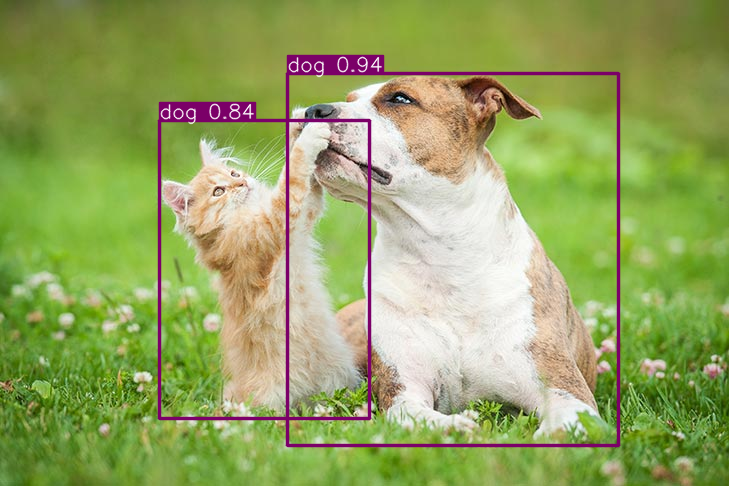

In [ ]:
results = yolo_model.predict(
    "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg", verbose=False)

results[0].show()

In [ ]:
from typing import Annotated
from langchain_core.tools import tool

class ObjectDetectingAndCountingInput(BaseModel):
    text: str = Field(description="Path or URL to the image in the format PNG or JPG/JPEG")

@tool(
    "detect_and_count_objects",
    description="Detect and count objects within the image. The return will be a dictionary, containing the counting dictionary (counting how many instance of each object class) and a list of dictionaries, containing the object names, confidence scores, and location in the image (in (x1, x2, y1, y2) format).",
    args_schema=ObjectDetectingAndCountingInput
)
def detect_and_count_object_tool(
    text: Annotated[str, "Path or URL to the image"]
):
    """Detect objects within the image using YOLOv11 model"""

    try:
        parsed: ImageInput = extractor_chain.invoke({"input": text})
    except Exception as e:
        return f"Failed to extract image URL: {str(e)}"

    image_path_or_url = parsed.image_path_or_url
    if not image_path_or_url:
        return "No image URL found in the input."

    results = yolo_model(image_path_or_url, verbose=False)

    detections = []
    counting = {}

    # Process each result
    for result in results:
        boxes = result.boxes
        class_names = result.names

        for box in boxes:
            class_id = int(box.cls[0])
            class_name = class_names[class_id]
            confidence = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            detections.append({
                'class': class_name,
                'confidence': confidence,
                'bbox': (x1, y1, x2, y2)
            })

            counting[class_name] = counting.get(class_name, 0) + 1

    return str({'counting': counting, 'detections': detections})

In [ ]:
detect_and_count_object_tool.invoke("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg")

Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg


"{'counting': {'dog': 2}, 'detections': [{'class': 'dog', 'confidence': 0.9411600232124329, 'bbox': (287, 73, 618, 445)}, {'class': 'dog', 'confidence': 0.8354390263557434, 'bbox': (159, 120, 369, 418)}]}"

### **Agent**

In [ ]:
vision_agent = create_react_agent(
    ### Your code here
)

In [ ]:
for chunk in vision_agent.stream(
    {"messages": [{"role": "user", "content": "how many dog in image: https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: vision_agent
Tool Calls:
  detect_and_count_objects (call_ZMQi8IvMsQU8nL3vZZP2aIPh)
 Call ID: call_ZMQi8IvMsQU8nL3vZZP2aIPh
  Args:
    text: https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg


Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg
Update from node tools:


================================= Tool Message =================================
Name: detect_and_count_objects

{'counting': {'dog': 2}, 'detections': [{'class': 'dog', 'confidence': 0.9411600232124329, 'bbox': (287, 73, 618,

## **Supervisor Agent**

In [ ]:
supervisor = create_supervisor(
    ### Your code here
)


## **Inference**

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the latest research on positional embeddings?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

I have gathered the latest research on positional embeddings. Here are three relevant papers:

1. **Improve Transformer Models with Better Relative Position Embeddings**  
   - **Authors**: Zhiheng Huang et al.  
   - **Published**: 2020-09-28  
   - **Summary**: The paper discusses enhancing transformers' positional embeddings through better integration of relative position information, proposing improvements over existing methods.

2. **Leveraging Multi-lingual Positive Insta

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the concept visualized in the image? Image: https://huggingface.co/datasets/tmnam20/Storage/resolve/main/rope.png Provide me detailed information about the concept. If possible, give me some research papers about it.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_vision_agent

Successfully transferred to vision_agent


Update from node vision_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The image illustrates the concept of **Rotary Position Embedding (RoPE)**, which utilizes rotation m

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How many dogs are there in the image? Image: https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_vision_agent

Successfully transferred to vision_agent




100%|██████████| 7.08k/7.08k [00:00<00:00, 12.4MB/s]


Update from node vision_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The image does not contain any dogs.




In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How many dogs are there in the image? Image: https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_vision_agent

Successfully transferred to vision_agent


Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg
Update from node vision_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

I have confirmed that there are 2 dogs in the image.




In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What color fur does the dog in the the picture? and looking for more information about this dog? Image: https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_vision_agent

Successfully transferred to vision_agent


Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg
Update from node vision_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: 